## Import essential libraries

In [12]:
import jax  

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

from jax_autovmap import autovmap

from tatva import Mesh, Operator, element, sparse
from tatva.plotting import plot_element_values

import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt

## Model setup

### Create the mesh

In [ ]:
def get_elements_on_curve(mesh, curve_func, tol=1e-3):
    coords = mesh.coords
    elements_2d = mesh.elements
    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return jnp.array([], dtype=int)
    
    return jnp.array(elements_1d)

def generate_cracked_plate_mesh(
    length: float,
    height: float,
    crack_tip_coords: tuple[float, float],
    mesh_size_crack: float,
    mesh_size_far: float,
    refine_dist_crack: float,
):
    """
    Generates a 2D mesh using the Gmsh Python API based on the provided .geo script.

    Args:
        length (float): Total length 'L' of the domain.
        height (float): Total height 'H' of the domain.
        lc (float): Characteristic length 'l' for the initial point.
        min_elem (float): Minimum element size for the refinement box.
        output_filename (str): Name of the output mesh file (e.g., 'model.msh').
    """
    import os

    mesh_dir = os.path.join(os.getcwd(), "meshes")
    os.makedirs(mesh_dir, exist_ok=True)
    output_filename = os.path.join(mesh_dir, "lefm.msh")

    gmsh.initialize()
    gmsh.model.add("refined_plate")

    # --- Use OpenCASCADE geometry kernel ---
    #gmsh.model.setFactory("OpenCASCADE")
    
    # --- Define script parameters ---
    h2 = 1.0
    epsilon = 1e-5
    depth = 0.0

    # --- Define geometry points ---
    # The last argument is the prescribed mesh size at that point.
    p1 = gmsh.model.geo.addPoint(0, epsilon, -depth / 2)
    p2 = gmsh.model.geo.addPoint(crack_tip_coords[0], crack_tip_coords[1], -depth / 2)
    p3 = gmsh.model.geo.addPoint(0, -epsilon, -depth / 2)
    p4 = gmsh.model.geo.addPoint(0, -height / 2, -depth / 2)
    p5 = gmsh.model.geo.addPoint(length, -height / 2, -depth / 2)
    p6 = gmsh.model.geo.addPoint(length, height / 2, -depth / 2)
    p7 = gmsh.model.geo.addPoint(0, height / 2, -depth / 2)

    # --- Define lines connecting the points ---
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p5)
    l5 = gmsh.model.geo.addLine(p5, p6)
    l6 = gmsh.model.geo.addLine(p6, p7)
    l7 = gmsh.model.geo.addLine(p7, p1)

    # --- Define curve loops and surfaces ---
    # A negative tag in a loop reverses the line's direction.
    loop1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, l5, l6, l7])
    
    surface1 = gmsh.model.geo.addPlaneSurface([loop1])

    #crack_tip_p = gmsh.model.geo.addPoint(crack_tip_coords[0], crack_tip_coords[1], 0)


    # Synchronize the CAD kernel with the Gmsh model
    gmsh.model.geo.synchronize()

    # --- Define Physical Groups ---
    # Physical groups are used to identify boundaries and domains.
    # Physical Line(2) = {{2}};
    gmsh.model.addPhysicalGroup(1, [loop1], 2) # dim=1 for lines
    # Physical Surface(1) = {{1, 2}};
    gmsh.model.addPhysicalGroup(2, [surface1], 1) # dim=2 for surfaces

    # --- Define Mesh Refinement Field ---
    dist_field_crack = gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(dist_field_crack, "PointsList", [p2])
    
    thresh_field_crack = gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(thresh_field_crack, "InField", dist_field_crack)
    gmsh.model.mesh.field.setNumber(thresh_field_crack, "SizeMin", mesh_size_crack)
    gmsh.model.mesh.field.setNumber(thresh_field_crack, "SizeMax", mesh_size_far)
    gmsh.model.mesh.field.setNumber(thresh_field_crack, "DistMin", refine_dist_crack)
    gmsh.model.mesh.field.setNumber(
        thresh_field_crack, "DistMax", refine_dist_crack * 2
    )

    
    # Set this field as the background field, which Gmsh uses to drive mesh generation.
    gmsh.model.mesh.field.setAsBackgroundMesh(thresh_field_crack)

    # --- Set global mesh options ---
    # These options prevent Gmsh from overriding the background field.
    gmsh.option.setNumber("Mesh.CharacteristicLengthFromPoints", 0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthFromCurvature", 0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthExtendFromBoundary", 0)
    
    # --- Generate the 2D mesh ---
    gmsh.model.mesh.generate(2)

    # --- Save the mesh and optionally launch the GUI ---
    gmsh.write(output_filename)
    print(f"Mesh saved to '{output_filename}'")
    gmsh.finalize()


    _mesh = meshio.read(output_filename)

    mesh = Mesh(
        coords=_mesh.points[:, :2],
        elements=_mesh.cells_dict["triangle"],
    )

    return mesh



In [14]:
crack_length = 0.08
length = 1.6
height = 0.32


refine_dist_crack = 0.02

params = {
    "length": length,
    "height": height,
    "crack_tip_coords": (crack_length, 0.0),
    "mesh_size_crack": 5e-4, 
    "mesh_size_far": 1e-2,
    "refine_dist_crack": refine_dist_crack,
}

mesh = generate_cracked_plate_mesh(**params)


n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.0045289s, CPU 0.005179s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.2575s, CPU 0.256982s)
Info    : 12922 nodes 25849 elements
Info    : Writing '/home/dab/moria/tatva/docs/examples/meshes/lefm.msh'...
Mesh saved to '/home/dab/moria/tatva/docs/examples/meshes/lefm.msh'
Info    : Done writing '/home/dab/moria/tatva/docs/examples/meshes/lefm.msh'



### Plot the mesh

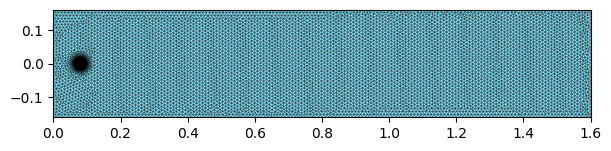

In [15]:
plt.figure(figsize=(6, 4), layout="constrained")
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.2,
    cmap="managua_r",
)

ax.set_aspect("equal")
ax.margins(0.0, 0.0)
plt.show()

## Defining material parameters

In [16]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter

E = 1e6
nu = 0.3

mu = E / (2 * (1 + nu))
lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))

mat = Material(mu=mu, lmbda=lmbda)

## Defining the total energy

In [17]:
tri = element.Tri3()
op = Operator(mesh, tri)


@autovmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.swapaxes(-1, -2))

@autovmap(eps=2)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@autovmap(grad_u=2)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sig, eps)


@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_grad = op.grad(u)
    energy_density = strain_energy(u_grad, mat.mu, mat.lmbda)
    return op.integrate(energy_density)

## Computing the internal forces and the stiffness matrix

In [18]:
sparsity_pattern = sparse.create_sparsity_pattern(mesh, n_dofs_per_node=n_dofs_per_node)

gradient = jax.jacrev(total_energy)
hessian_sparse = sparse.jacfwd(gradient, sparsity_pattern=sparsity_pattern)

## Applying Dirichlet boundary conditions

In [19]:
prestrain = 0.01

y_max = np.max(mesh.coords[:, 1])
y_min = np.min(mesh.coords[:, 1])
x_min = np.min(mesh.coords[:, 0])
x_max = np.max(mesh.coords[:, 0])

height = y_max - y_min
applied_displacement = prestrain * height

top_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
bottom_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_min))[0]
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_min))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_max))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * top_nodes,
        2 * top_nodes + 1,
        2 * bottom_nodes,
        2 * bottom_nodes + 1,
    ]
)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

prescribed_values = jnp.zeros(n_dofs)
prescribed_values = prescribed_values.at[2 * top_nodes + 1].set(
    applied_displacement / 2.0
)
prescribed_values = prescribed_values.at[2 * bottom_nodes + 1].set(
    -applied_displacement / 2.0
)

zero_indices, one_indices = sparse.get_bc_indices(sparsity_pattern, fixed_dofs)

## Solve the system

In [20]:
import scipy.sparse as sp

def newton_scipy_solver(
    u,
    fext,
    gradient,
    hessian_sparse,
    fixed_dofs,
    zero_indices,
    one_indices,
):
    fint = gradient(u)
    K_sparse = hessian_sparse(u)
    indices = K_sparse.indices

    du = jnp.zeros_like(u)

    iiter = 0
    norm_res = 1.0

    tol = 1e-8
    max_iter = 110

    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)

        K_data_lifted = K_sparse.data.at[zero_indices].set(0)
        K_data_lifted = K_data_lifted.at[one_indices].set(1)

        K_csr = sp.csr_matrix((K_data_lifted, (indices[:, 0], indices[:, 1])))

        du = sp.linalg.spsolve(K_csr, residual)

        u = u.at[:].add(du)
        fint = gradient(u)
        K_sparse = hessian_sparse(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        norm_res = jnp.linalg.norm(residual)
        print(f"  Residual: {norm_res:.2e}")
        iiter += 1

    return u, norm_res

In [21]:
u_prev = jnp.zeros(n_dofs)
fext = jnp.zeros(n_dofs)

n_steps = 5

applied_displacement = prescribed_values / n_steps  # displacement increment
for step in range(n_steps):
    print(f"Step {step+1}/{n_steps}")
    u_prev = u_prev.at[fixed_dofs].add(applied_displacement[fixed_dofs])

    
    u_new, rnorm = newton_scipy_solver(
        u_prev,
        fext,
        gradient,
        hessian_sparse,
        fixed_dofs,
        zero_indices,
        one_indices,
    )
    

    u_prev = u_new

u_solution = u_prev.reshape(n_nodes, n_dofs_per_node)

Step 1/5
  Residual: 1.67e-11
Step 2/5
  Residual: 1.83e-11
Step 3/5
  Residual: 1.92e-11
Step 4/5
  Residual: 2.20e-11
Step 5/5
  Residual: 2.37e-11


## Plotting the stress field

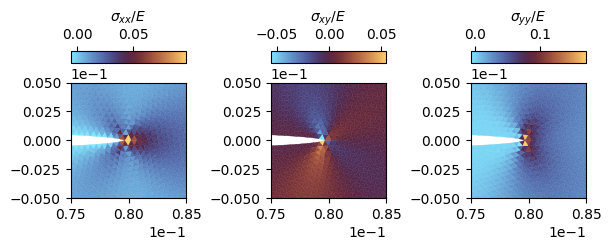

In [26]:
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)

fig, axs = plt.subplots(1, 3, figsize=(6, 4), layout="constrained")

plot_element_values(
    mesh.coords,
    mesh.elements,
    stresses[:, 0, 0]/E,
    u=u_solution,
    ax=axs[0],
    label=r"$\sigma_{xx}/E$",
)

axs[0].ticklabel_format(axis="both", style="sci", scilimits=(-1, -1))
axs[0].set_xlim(crack_length - refine_dist_crack / 4, crack_length + refine_dist_crack / 4)
axs[0].set_ylim(-refine_dist_crack / 4, refine_dist_crack / 4)
axs[0].set_aspect("equal")
axs[0].margins(0.0, 0.0)

plot_element_values(
    mesh.coords,
    mesh.elements,
    stresses[:, 0, 1]/E,
    u=u_solution,
    ax=axs[1], 
    label=r"$\sigma_{xy}/E$",
)

axs[1].ticklabel_format(axis='both', style='sci', scilimits=(-1, -1))
axs[1].set_xlim(crack_length-refine_dist_crack/4, crack_length + refine_dist_crack/4)
axs[1].set_ylim(-refine_dist_crack/4, refine_dist_crack/4)
axs[1].set_aspect("equal")
axs[1].margins(0.0, 0.0)

plot_element_values(
    mesh.coords,
    mesh.elements, 
    stresses[:, 1, 1]/E, 
    u=u_solution,
    ax=axs[2], 
    label=r"$\sigma_{yy}/E$"
)

axs[2].ticklabel_format(axis='both', style='sci', scilimits=(-1, -1))
axs[2].set_xlim(crack_length-refine_dist_crack/4, crack_length + refine_dist_crack/4)
axs[2].set_ylim(-refine_dist_crack/4, refine_dist_crack/4)
axs[2].set_aspect("equal")
axs[2].margins(0.0, 0.0)
plt.show()